#CheXpert

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import ToTensor,Resize

from PIL import Image
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch.nn.functional as func

from sklearn.metrics.ranking import roc_auc_score
import sklearn.metrics as metrics
import random

use_gpu = torch.cuda.is_available()

Mount google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
baseFolder  = "CheXpert-v1.0-small/"

In [3]:
#Utility functions for cleaning the data

def cleanLabel(x):
    
    labelCount = 0    
    if x.Pleural_Effusion == 1:
        labelCount += 1
    if x.Edema == 1:
        labelCount += 1
    if x.Cardiomegaly ==1:
        labelCount += 1
    if x.Pneumonia == 1:
        labelCount += 1
    return labelCount
    
    

def getLabel(x):
    
    if x.Pleural_Effusion ==1:
        return "Pleural_Effusion"
    elif x.Edema == 1:
        return "Edema"
    elif x.Cardiomegaly==1:
        return "Cardiomegaly"
    elif x.Pneumonia == 1:
        return "Pneumonia"
    else:
        return "None"

In [4]:


#Dataframe columns
cols = ['Path',
 'Sex',
 'Age',
 'View',
 'AP/PA',
 'No_Finding',
 'Enlarged_Cardiomediastinum',
 'Cardiomegaly',
 'Lung_Opacity',
 'Lung_Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Effusion',
 'Pleural_Other',
 'Fracture',
 'Support_Devices']

pathFileTrain = baseFolder + 'train.csv'
pathFileValid = baseFolder + 'valid.csv'

## Dataloader for using 14 classes

Need to change uncertain labels (Trying 1s policy)


In [5]:
#For 4 classes
labelMap = {"Pleural_Effusion":0, "Edema":1,"Cardiomegaly":2,"Pneumonia":3}

def getLabelDf(x):
    x = x[36:]          #To account for the extra "././" added before the Path variable
    x = df.loc[df.Path == x] 
    return labelMap[x.label.values[0]]

In [6]:
class LungDataset(Dataset):
    def __init__(self, baseFolder, file, transform=None):
        image_files = []
        labels = []

        with open(file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            k=0
            for line in csvReader:
                k+=1
                image_file= line[0]
                
                #Create a 14 class label with 0s and 1s for the corresponding pathologies
                label = line[5:]
                
                #Handling uncertainity
                # TODO: Also try 0s for Us
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            label[i] = 1
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0       
                #TODO: Change when running locally!    
                image_files.append(baseFolder + image_file)
                labels.append(label)

        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        label = self.labels[index]
        location = self.image_files[index]
        image = Image.open(location).convert('RGB')
        
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_files)

In [7]:
img_size = (256, 256)
#Transformations
transformList = []
transformList.append(transforms.Resize(img_size))
transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
transformList.append(transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))      
transformSequence=transforms.Compose(transformList)

In [8]:

trainDataset = LungDataset('',pathFileTrain, transformSequence)  

validationDataset = LungDataset('',pathFileValid, transformSequence)  

In [9]:
e = next(iter(trainDataset))
e[0].size()

torch.Size([3, 256, 256])

In [10]:
train_data_loader = DataLoader(trainDataset, batch_size= 16, shuffle = True)
validation_loader = DataLoader(validationDataset, batch_size= 16, shuffle = True)

In [11]:
for image, label in train_data_loader:
    print(label)
    
    break;

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
        [0

## Logger

In [12]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi

Ngrok already installed


In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Tensorboard Link: http://c672d1c4.ngrok.io


In [13]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
import tensorflow as tf
import numpy as np
import scipy.misc 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x


class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()
logger = Logger('./logs')


## CNN - 14 classes


In [14]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

In [15]:
device = torch.device('cuda:0')

input_size = 196608
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(4608, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256,num_classes)
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out


In [16]:
def train(net, optimizer, criterion, train_loader, test_loader, epochs, size, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    for epoch in range(epochs):
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            #print(loss)
            optimizer.step()
            _, prediction = torch.max(outputs,1)
            del images
            del labels
            #print(outputs)
            #print(labels)
            #print(prediction)
            ##total += labels.size(0)
            #correct += (prediction==labels).sum().item()
            #accuracy = (labels == prediction.squeeze()).float().mean()
            overall_step+=1
            if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item()}

              for tag, value in info.items():
                logger.scalar_summary(tag, value, overall_step+1)
    

In [17]:
num_classes = 14
learning_rate = 0.00003
model = Net(num_classes).cuda()
criterion = torch.nn.BCELoss(size_average = True)
optimizer = torch.optim.Adam (model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
epochs = 10

In [18]:
train(model, optimizer, criterion, train_data_loader, validation_loader, epochs, input_size , 'conv-14c', True)

Epoch [1/10], Step [100/13964], Loss: 0.4566
Epoch [1/10], Step [200/13964], Loss: 0.4415
Epoch [1/10], Step [300/13964], Loss: 0.3738
Epoch [1/10], Step [400/13964], Loss: 0.4732
Epoch [1/10], Step [500/13964], Loss: 0.4153
Epoch [1/10], Step [600/13964], Loss: 0.3531
Epoch [1/10], Step [700/13964], Loss: 0.4167
Epoch [1/10], Step [800/13964], Loss: 0.3647
Epoch [1/10], Step [900/13964], Loss: 0.3963
Epoch [1/10], Step [1000/13964], Loss: 0.4493
Epoch [1/10], Step [1100/13964], Loss: 0.3613
Epoch [1/10], Step [1200/13964], Loss: 0.3753
Epoch [1/10], Step [1300/13964], Loss: 0.3825
Epoch [1/10], Step [1400/13964], Loss: 0.3787
Epoch [1/10], Step [1500/13964], Loss: 0.3906
Epoch [1/10], Step [1600/13964], Loss: 0.3601
Epoch [1/10], Step [1700/13964], Loss: 0.4062
Epoch [1/10], Step [1800/13964], Loss: 0.3930
Epoch [1/10], Step [1900/13964], Loss: 0.3892
Epoch [1/10], Step [2000/13964], Loss: 0.3653
Epoch [1/10], Step [2100/13964], Loss: 0.4063
Epoch [1/10], Step [2200/13964], Loss: 0.34

Epoch [2/10], Step [4000/13964], Loss: 0.3306
Epoch [2/10], Step [4100/13964], Loss: 0.4333
Epoch [2/10], Step [4200/13964], Loss: 0.3438
Epoch [2/10], Step [4300/13964], Loss: 0.3412
Epoch [2/10], Step [4400/13964], Loss: 0.3911
Epoch [2/10], Step [4500/13964], Loss: 0.4043
Epoch [2/10], Step [4600/13964], Loss: 0.3229
Epoch [2/10], Step [4700/13964], Loss: 0.3873
Epoch [2/10], Step [4800/13964], Loss: 0.3727
Epoch [2/10], Step [4900/13964], Loss: 0.3474
Epoch [2/10], Step [5000/13964], Loss: 0.4778
Epoch [2/10], Step [5100/13964], Loss: 0.3638
Epoch [2/10], Step [5200/13964], Loss: 0.3828
Epoch [2/10], Step [5300/13964], Loss: 0.4191
Epoch [2/10], Step [5400/13964], Loss: 0.3601
Epoch [2/10], Step [5500/13964], Loss: 0.3766
Epoch [2/10], Step [5600/13964], Loss: 0.3636
Epoch [2/10], Step [5700/13964], Loss: 0.3922
Epoch [2/10], Step [5800/13964], Loss: 0.3795
Epoch [2/10], Step [5900/13964], Loss: 0.3405
Epoch [2/10], Step [6000/13964], Loss: 0.3828
Epoch [2/10], Step [6100/13964], L

Epoch [3/10], Step [7900/13964], Loss: 0.3731
Epoch [3/10], Step [8000/13964], Loss: 0.3432
Epoch [3/10], Step [8100/13964], Loss: 0.4318
Epoch [3/10], Step [8200/13964], Loss: 0.3550
Epoch [3/10], Step [8300/13964], Loss: 0.4353
Epoch [3/10], Step [8400/13964], Loss: 0.3428
Epoch [3/10], Step [8500/13964], Loss: 0.3488
Epoch [3/10], Step [8600/13964], Loss: 0.3926
Epoch [3/10], Step [8700/13964], Loss: 0.3177
Epoch [3/10], Step [8800/13964], Loss: 0.3689
Epoch [3/10], Step [8900/13964], Loss: 0.3778
Epoch [3/10], Step [9000/13964], Loss: 0.3250
Epoch [3/10], Step [9100/13964], Loss: 0.3943
Epoch [3/10], Step [9200/13964], Loss: 0.4325
Epoch [3/10], Step [9300/13964], Loss: 0.3765
Epoch [3/10], Step [9400/13964], Loss: 0.3576
Epoch [3/10], Step [9500/13964], Loss: 0.3575
Epoch [3/10], Step [9600/13964], Loss: 0.4504
Epoch [3/10], Step [9700/13964], Loss: 0.3434
Epoch [3/10], Step [9800/13964], Loss: 0.4218
Epoch [3/10], Step [9900/13964], Loss: 0.4451
Epoch [3/10], Step [10000/13964], 

Epoch [4/10], Step [11800/13964], Loss: 0.4196
Epoch [4/10], Step [11900/13964], Loss: 0.4307
Epoch [4/10], Step [12000/13964], Loss: 0.4226
Epoch [4/10], Step [12100/13964], Loss: 0.3429
Epoch [4/10], Step [12200/13964], Loss: 0.3896
Epoch [4/10], Step [12300/13964], Loss: 0.3511
Epoch [4/10], Step [12400/13964], Loss: 0.3880
Epoch [4/10], Step [12500/13964], Loss: 0.3215
Epoch [4/10], Step [12600/13964], Loss: 0.3632
Epoch [4/10], Step [12700/13964], Loss: 0.4245
Epoch [4/10], Step [12800/13964], Loss: 0.3644
Epoch [4/10], Step [12900/13964], Loss: 0.3880
Epoch [4/10], Step [13000/13964], Loss: 0.3441
Epoch [4/10], Step [13100/13964], Loss: 0.3682
Epoch [4/10], Step [13200/13964], Loss: 0.3792
Epoch [4/10], Step [13300/13964], Loss: 0.3648
Epoch [4/10], Step [13400/13964], Loss: 0.4066
Epoch [4/10], Step [13500/13964], Loss: 0.3728
Epoch [4/10], Step [13600/13964], Loss: 0.4600
Epoch [4/10], Step [13700/13964], Loss: 0.3604
Epoch [4/10], Step [13800/13964], Loss: 0.3870
Epoch [4/10],

Epoch [6/10], Step [1800/13964], Loss: 0.3578
Epoch [6/10], Step [1900/13964], Loss: 0.3304
Epoch [6/10], Step [2000/13964], Loss: 0.3475
Epoch [6/10], Step [2100/13964], Loss: 0.3412
Epoch [6/10], Step [2200/13964], Loss: 0.4066
Epoch [6/10], Step [2300/13964], Loss: 0.4262
Epoch [6/10], Step [2400/13964], Loss: 0.3477
Epoch [6/10], Step [2500/13964], Loss: 0.3514
Epoch [6/10], Step [2600/13964], Loss: 0.3241
Epoch [6/10], Step [2700/13964], Loss: 0.3764
Epoch [6/10], Step [2800/13964], Loss: 0.4296
Epoch [6/10], Step [2900/13964], Loss: 0.3460
Epoch [6/10], Step [3000/13964], Loss: 0.4270
Epoch [6/10], Step [3100/13964], Loss: 0.4023
Epoch [6/10], Step [3200/13964], Loss: 0.4636
Epoch [6/10], Step [3300/13964], Loss: 0.3892
Epoch [6/10], Step [3400/13964], Loss: 0.3808
Epoch [6/10], Step [3500/13964], Loss: 0.3685
Epoch [6/10], Step [3600/13964], Loss: 0.4092
Epoch [6/10], Step [3700/13964], Loss: 0.4411
Epoch [6/10], Step [3800/13964], Loss: 0.3240
Epoch [6/10], Step [3900/13964], L

Epoch [7/10], Step [5700/13964], Loss: 0.2990
Epoch [7/10], Step [5800/13964], Loss: 0.3715
Epoch [7/10], Step [5900/13964], Loss: 0.4297
Epoch [7/10], Step [6000/13964], Loss: 0.3382
Epoch [7/10], Step [6100/13964], Loss: 0.3807
Epoch [7/10], Step [6200/13964], Loss: 0.3923
Epoch [7/10], Step [6300/13964], Loss: 0.3584
Epoch [7/10], Step [6400/13964], Loss: 0.4131
Epoch [7/10], Step [6500/13964], Loss: 0.3707
Epoch [7/10], Step [6600/13964], Loss: 0.3750
Epoch [7/10], Step [6700/13964], Loss: 0.3733
Epoch [7/10], Step [6800/13964], Loss: 0.3210
Epoch [7/10], Step [6900/13964], Loss: 0.3854
Epoch [7/10], Step [7000/13964], Loss: 0.3616
Epoch [7/10], Step [7100/13964], Loss: 0.4032
Epoch [7/10], Step [7200/13964], Loss: 0.3421
Epoch [7/10], Step [7300/13964], Loss: 0.3492
Epoch [7/10], Step [7400/13964], Loss: 0.2959
Epoch [7/10], Step [7500/13964], Loss: 0.3929
Epoch [7/10], Step [7600/13964], Loss: 0.3865
Epoch [7/10], Step [7700/13964], Loss: 0.3985
Epoch [7/10], Step [7800/13964], L

Epoch [8/10], Step [9600/13964], Loss: 0.4079
Epoch [8/10], Step [9700/13964], Loss: 0.4205
Epoch [8/10], Step [9800/13964], Loss: 0.2937
Epoch [8/10], Step [9900/13964], Loss: 0.3470
Epoch [8/10], Step [10000/13964], Loss: 0.3578
Epoch [8/10], Step [10100/13964], Loss: 0.3929
Epoch [8/10], Step [10200/13964], Loss: 0.3640
Epoch [8/10], Step [10300/13964], Loss: 0.3674
Epoch [8/10], Step [10400/13964], Loss: 0.3288
Epoch [8/10], Step [10500/13964], Loss: 0.3301
Epoch [8/10], Step [10600/13964], Loss: 0.3718
Epoch [8/10], Step [10700/13964], Loss: 0.3604
Epoch [8/10], Step [10800/13964], Loss: 0.3556
Epoch [8/10], Step [10900/13964], Loss: 0.3246
Epoch [8/10], Step [11000/13964], Loss: 0.4047
Epoch [8/10], Step [11100/13964], Loss: 0.2933
Epoch [8/10], Step [11200/13964], Loss: 0.3664
Epoch [8/10], Step [11300/13964], Loss: 0.3297
Epoch [8/10], Step [11400/13964], Loss: 0.3401
Epoch [8/10], Step [11500/13964], Loss: 0.4056
Epoch [8/10], Step [11600/13964], Loss: 0.3661
Epoch [8/10], Ste

Epoch [9/10], Step [13400/13964], Loss: 0.3241
Epoch [9/10], Step [13500/13964], Loss: 0.3488
Epoch [9/10], Step [13600/13964], Loss: 0.3516
Epoch [9/10], Step [13700/13964], Loss: 0.3264
Epoch [9/10], Step [13800/13964], Loss: 0.3944
Epoch [9/10], Step [13900/13964], Loss: 0.3836
Epoch [10/10], Step [100/13964], Loss: 0.3859
Epoch [10/10], Step [200/13964], Loss: 0.3534
Epoch [10/10], Step [300/13964], Loss: 0.3745
Epoch [10/10], Step [400/13964], Loss: 0.4174
Epoch [10/10], Step [500/13964], Loss: 0.4224
Epoch [10/10], Step [600/13964], Loss: 0.3160
Epoch [10/10], Step [700/13964], Loss: 0.3629
Epoch [10/10], Step [800/13964], Loss: 0.3516
Epoch [10/10], Step [900/13964], Loss: 0.4172
Epoch [10/10], Step [1000/13964], Loss: 0.3277
Epoch [10/10], Step [1100/13964], Loss: 0.4363
Epoch [10/10], Step [1200/13964], Loss: 0.4050
Epoch [10/10], Step [1300/13964], Loss: 0.3251
Epoch [10/10], Step [1400/13964], Loss: 0.3074
Epoch [10/10], Step [1500/13964], Loss: 0.4104
Epoch [10/10], Step [1

In [19]:
model

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=14, bias=True)
  (sigmoid): Sigmoid()
)

In [23]:
torch.save(model.state_dict(), 'cnn_14_10epchs.pt')

In [20]:

def computeAUROC (data, predicted, classCount):

    auroc = []

    data_np = data.cpu().numpy()
    data_np_pred = predicted.cpu().numpy()

    for i in range(classCount):
        try:
            auroc.append(roc_auc_score(data_np[:, i], data_np_pred[:, i]))
        except ValueError:
            pass
    return auroc



def test(model, test_loader, class_count, class_names):   

   
    out = torch.FloatTensor().cuda()
    out_pred = torch.FloatTensor().cuda()
    model.eval()
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            target = label.cuda()
            out = torch.cat((out, target), 0).cuda()

            outV = model(image)
            out_pred = torch.cat((out_pred, outV), 0)
        
    aurocIndividual = computeAUROC(out, out_pred, class_count)
    aurocMean = np.array(aurocIndividual).mean()

    print ('AUROC mean ', aurocMean)

    for i in range (0, len(aurocIndividual)):
        print (class_names[i], ' ', aurocIndividual[i])

    return out, out_pred

In [21]:

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
out, out_pred = test(model, validation_loader, 14, class_names)

AUROC mean  0.7348869240513627
No Finding   0.8825187969924813
Enlarged Cardiomediastinum   0.5189724770642201
Cardiomegaly   0.798458540042523
Lung Opacity   0.8619929453262787
Lung Lesion   0.06008583690987124
Edema   0.8810111699000588
Consolidation   0.8846675712347354
Pneumonia   0.7643805309734514
Atelectasis   0.78887987012987
Pneumothorax   0.6814159292035398
Pleural Effusion   0.8699615693985163
Pleural Other   0.7725321888412018
Fracture   0.7886525866509677


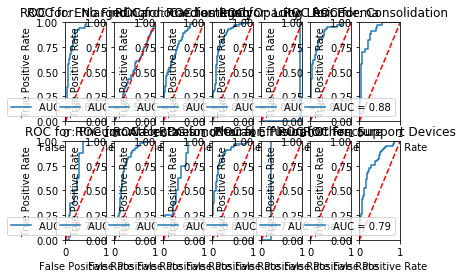

In [22]:
for i in range(14):
    fpr, tpr, threshold = metrics.roc_curve(out.cpu()[:,i], out_pred.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 20
    plt.rcParams["figure.figsize"] = fig_size
    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


plt.show()